In [121]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

bs = 100
# # MNIST Dataset
# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [48]:
for (data,_) in train_loader:
    print(np.shape(data))

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([10

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 25))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# # build model
# vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
# if torch.cuda.is_available():
#     vae.cuda()

In [3]:
class agent():
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        self.vae = VAE(x_dim=x_dim, h_dim1= h_dim1, h_dim2=h_dim2, z_dim=z_dim)
        if torch.cuda.is_available():
            self.vae.cuda()
    
    def generate_signal(self):
        # TODO: maybe just use random zs instead of sampling from this gaussian?!
        mu = torch.normal(0., 1., size=(2,)).cuda()
        log_var = torch.normal(1., 1., size=(2,)).cuda()
        
        z = self.vae.sampling(mu, log_var)
        signal = self.vae.decoder(z)
        return signal

# populate agents
numAgents = 50

agents = []
for i in range(0, numAgents):
    agents.append(agent(x_dim=25, h_dim1 = 15, h_dim2=10, z_dim=2))

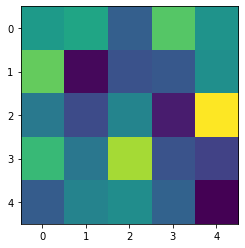

In [51]:
test = agents[0].generate_signal()
test2 = test[0].cpu().detach().numpy()
plt.imshow(test2.reshape(5, 5))

In [27]:
datatest = [agents[0].generate_signal() for i in range(0, 25)]
datatest = torch.utils.data.DataLoader(dataset=datatest, batch_size=None)

In [37]:
datatest

In [134]:
for agent in agents:
    agent.optimizer = optim.Adam(agent.vae.parameters())
    
# return reconstruction error + KL divergence losses
# def loss_function(recon_x, x, mu, log_var):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 25).detach(), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return BCE + KLD

def loss_function_listener(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 25).detach(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def loss_function_speaker(recon_x, x, mu, log_var):
    BCE = -F.binary_cross_entropy(recon_x, x.view(-1, 25).detach(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [132]:
def train_interact(epoch):
    
    for agent in agents:
        agent.vae.train()
        agent.train_loss = 0
    train_loss = 0
    
    numExamples = 100
    
    for i, agent in enumerate(tqdm(agents, position=0, leave=True)):

        # indices of neighbouring agents (1D circular chain)
        neighbours = (i + 1) % len(agents), (i - 1) % len(agents)

        # generate data from neighbours
        # reconstruct
        # backprop
        for n in neighbours:
            data = torch.stack([agents[n].generate_signal() for i in range(0, numExamples)])
            data = torch.utils.data.DataLoader(dataset=data, batch_size=4)


            for d in data:
                # listener loss
                recon_batch, mu, log_var = agent.vae(d)
                agent.loss = loss_function_listener(recon_batch, d, mu, log_var)

                agent.loss.backward(retain_graph=True)
                agent.train_loss_listen += agent.loss.item()
                agent.optimizer.step()
                
                # speaker loss
                
                # TODO: optimizer needs to apply only to decoder, freeze encoder layers
                # gradients need to push through all the way from the listener
                agents[n].loss = loss_function_speaker(recon_batch, d, mu, log_var)
                agents[n].loss.backward(retain_graph=True)
                agents[n].train_loss_speak += agents[n].loss.item()
                agents[n].optimizer.step()
                
    avg_loss_listen = np.mean([a.train_loss_listen for a in agents])
    avg_loss_speak = np.mean([a.train_loss_speak for a in agents])
    print(f'====> Epoch: {epoch} Average listen loss: {avg_loss_listen:.4f}, Average speak loss: {avg_loss_speak:.4f}')

In [140]:
for params in agents[0].vae.fc2.parameters():
    print(params)

Parameter containing:
tensor([[-7.2155e+01, -5.0214e-02,  1.1081e-01, -7.1836e+01,  7.1681e+01,
         -1.0201e-01, -1.6576e-02,  1.2974e-01, -6.7677e-02, -7.1735e+01,
         -7.2075e+01, -2.4978e-01, -2.7136e-02, -1.8950e-01,  7.1185e+01],
        [-1.0848e-01,  1.5095e-02, -1.0947e-01, -3.1255e-02, -1.8277e-01,
         -1.9434e-01,  1.1174e-01, -9.3340e-02,  2.2777e-01, -1.5442e-01,
         -1.5631e-01,  3.5254e-02, -2.1784e-01, -2.0108e-01,  1.4559e-01],
        [-7.1828e+01, -1.4973e-01, -6.9868e-02, -7.1792e+01, -7.1917e+01,
         -1.7185e-02, -1.2685e-01, -1.7665e-01,  3.6417e-02, -7.2015e+01,
         -7.2031e+01, -1.8980e-01, -1.6549e-01,  2.3527e-01, -7.1735e+01],
        [-7.1910e+01, -4.2684e-02,  1.8088e-01, -7.1924e+01, -1.6533e-01,
         -4.3102e-02, -6.6222e-03,  2.4880e-01,  1.7140e-01, -7.2067e+01,
         -7.2036e+01,  2.3215e-01,  1.7158e-01, -2.0565e-01, -7.2148e+01],
        [-7.2171e+01, -2.4272e-01,  2.1495e-01, -7.2050e+01, -7.2073e+01,
          2.

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [133]:
for epoch in range(1, 51):
#     print(epoch)
    train_interact(epoch)
#     test()

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


                                     

                 
  0%|          | 0/50 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 178.6805


 22%|██▏       | 11/50 [00:10<00:37,  1.05it/s]

KeyboardInterrupt: 

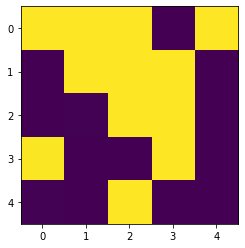

In [96]:
plt.imshow(agents[49].generate_signal().cpu().detach().numpy().reshape(5, 5))

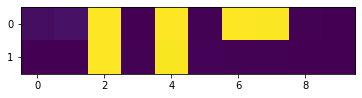

In [117]:
w = agents[1].vae.fc4.weight
w = w.cpu().detach().numpy().reshape(2, 10)
plt.imshow(w)

In [8]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

C:\Users\lyeoni\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
